In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors


In [ ]:
!unzip /content/tuberculosis-tb-chest-xray-dataset.zip

Archive:  /content/tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png 

In [ ]:
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import cv2
import io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.utils import shuffle
from keras import layers,models,optimizers
import ipywidgets as widgets
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,Dropout,BatchNormalization,Concatenate,AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from google.colab.patches import cv2_imshow

In [ ]:
labels=["Tuberculosis","Normal"]

In [ ]:
X=[]
Y=[]

In [ ]:
image_size=(227,227)

In [ ]:
for i in labels:
  path="/content/TB_Chest_Radiography_Database/"+i+"/"
  print(path)
  fileRead=glob.glob(path+"*")
  print(len(fileRead))

  for j in fileRead:
    image=cv2.imread(j)
    image=cv2.resize(image,image_size)
    X.append(image)
    Y.append(i)



/content/TB_Chest_Radiography_Database/Tuberculosis/
700
/content/TB_Chest_Radiography_Database/Normal/
3500


In [ ]:
X=np.array(X)
Y=np.array(Y)


In [ ]:
for i in labels:
  path="/content/TB_Chest_Radiography_Database/"+i+"/"
  print(path)
  fileRead=glob.glob(path+"*")
  print(fileRead[5])


/content/TB_Chest_Radiography_Database/Tuberculosis/
/content/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-99.png
/content/TB_Chest_Radiography_Database/Normal/
/content/TB_Chest_Radiography_Database/Normal/Normal-34.png


In [ ]:
Temp_y = []
for i in Y:
    Temp_y.append(labels.index(i))


In [ ]:
Y = np.array(Temp_y)
Y = to_categorical(Y)

print(Y[0])

[1. 0.]


In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0001)
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Concatenate

In [ ]:
Google_X_train,Google_X_test,Google_Y_train,Google_Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Concatenate

def inception_module(prev_layer, filters):
    tower_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(prev_layer)

    tower_3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(prev_layer)
    tower_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(tower_3x3_reduce)

    tower_5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(prev_layer)
    tower_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(tower_5x5_reduce)

    tower_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(prev_layer)
    tower_pool_1x1 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(tower_pool)

    return Concatenate(axis=-1)([tower_1x1, tower_3x3, tower_5x5, tower_pool_1x1])

# Input layer
input_layer = Input(shape=(227, 227, 3))

# Convolution and Pooling layers
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception modules
x = inception_module(x, [64, 128, 128, 32, 32, 32])
x = inception_module(x, [128, 192, 96, 64, 64, 64])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, [192, 208, 48, 64, 64, 64])
x = inception_module(x, [160, 224, 64, 64, 64, 128])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, [128, 256, 64, 64, 64, 128])
x = inception_module(x, [112, 288, 64, 64, 64, 128])
x = inception_module(x, [256, 320, 128, 128, 128, 128])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Fully connected layers
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
output_layer = Dense(2, activation='softmax')(x)  # Assuming 4 classes for the classification task

# Create the model
GoogleNet = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
GoogleNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Print the model summary
GoogleNet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 114, 114,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 57, 57,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 57, 57,    │      8,320 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 57, 57,    │      2,080 │ max_pooling2d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 57, 57,    │          0 │ max_pooling2d_11… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 57, 57,    │      4,160 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 57, 57,    │    147,584 │ conv2d_45[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 57, 57,    │     25,632 │ conv2d_47[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 57, 57,    │      2,080 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 57, 57,    │          0 │ conv2d_44[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_46[0][0],  │
│                     │                   │            │ conv2d_48[0][0],  │
│                     │                   │            │ conv2d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 57, 57,    │     49,344 │ concatenate_7[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 57, 57,    │     16,448 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 57, 57,    │          0 │ concatenate_7[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 57, 57,    │     32,896 │ concatenate_7[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 57, 57,    │    165,984 │ conv2d_51[0][0]   │
│                     │ 96)               │            │                 

 Total params: 6,102,290 (23.28 MB)

 Trainable params: 6,102,290 (23.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Google_history=GoogleNet.fit(Google_X_train,Google_Y_train, validation_data=(Google_X_test,Google_Y_test),epochs=10,batch_size=32,verbose=1)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 388ms/step - accuracy: 0.8219 - loss: 2.5248 - val_accuracy: 0.9476 - val_loss: 0.1177
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9385 - loss: 0.1541 - val_accuracy: 0.9702 - val_loss: 0.0665
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 206ms/step - accuracy: 0.9708 - loss: 0.0792 - val_accuracy: 0.9845 - val_loss: 0.0505
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.9818 - loss: 0.0456 - val_accuracy: 0.9560 - val_loss: 0.1072
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9788 - loss: 0.0569 - val_accuracy: 0.9845 - val_loss: 0.0478
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9860 - loss: 0.0343 - val_accuracy: 0.9821 - val_loss: 0.0559
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9872 - loss: 0.0274 - val_accuracy: 0.9881 - val_loss: 0.0393
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step - accuracy: 0.9950 - loss: 0

In [ ]:
train_loss = Google_history.history['loss']
train_accuracy = Google_history.history['accuracy']
test_loss = Google_history.history['val_loss']
test_accuracy = Google_history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)


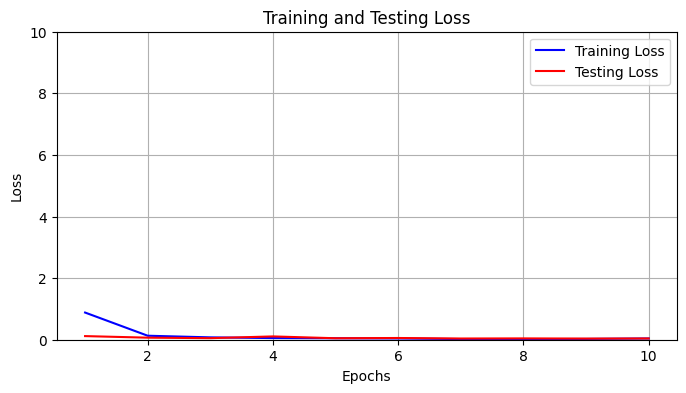

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,10)
plt.legend()
plt.grid(True)
plt.show()

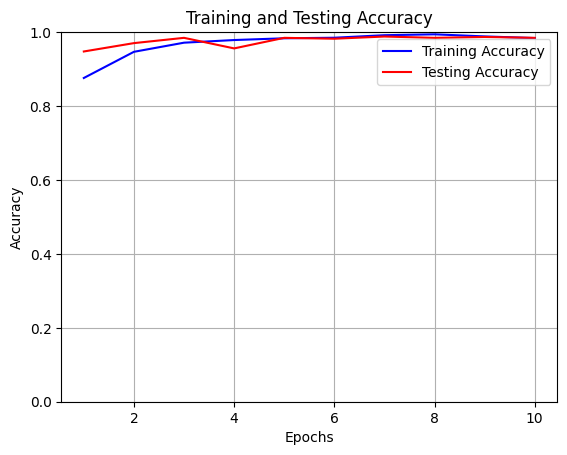

In [ ]:
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step


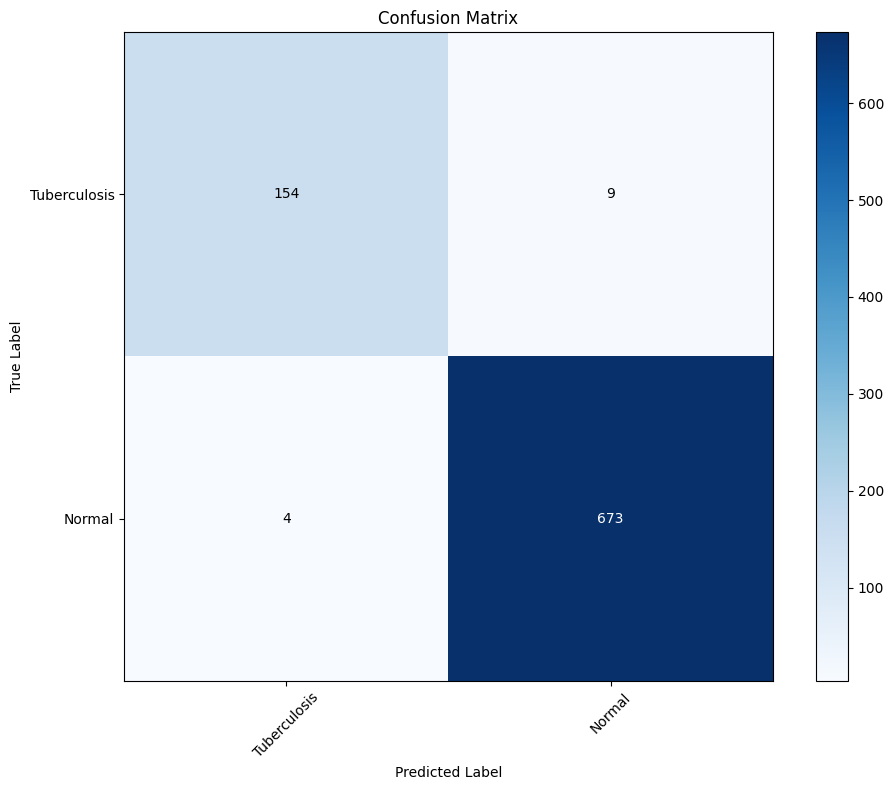

In [ ]:
y_pred = GoogleNet.predict(Google_X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Google_Y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


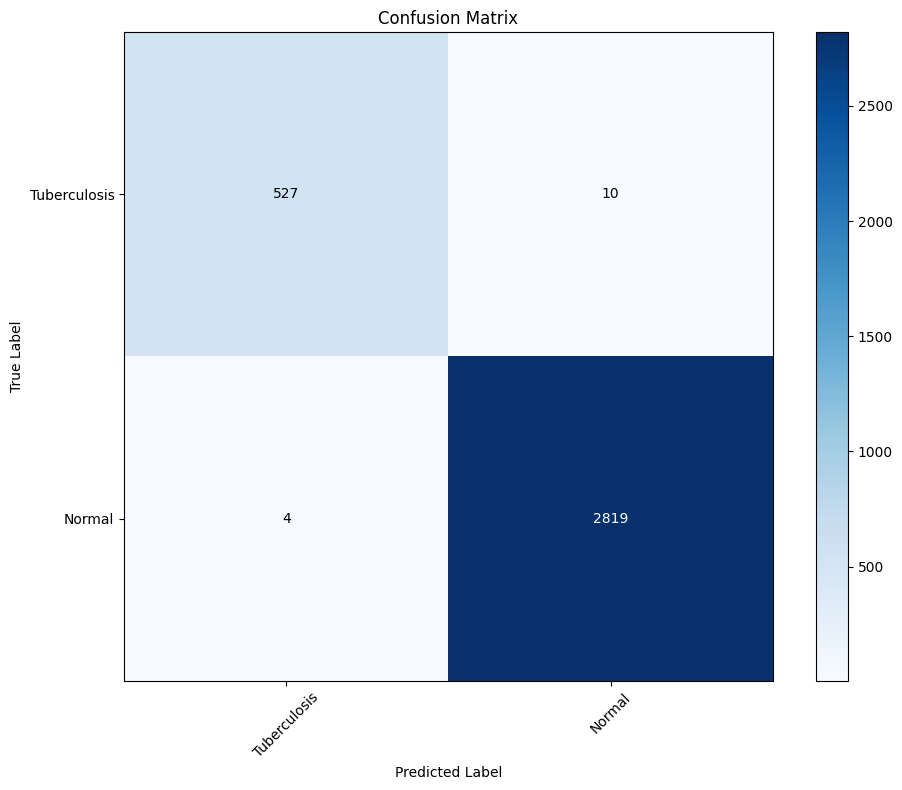

In [ ]:
y_pred = GoogleNet.predict(Google_X_train)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Google_Y_train, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
def Google_pred(path):
  img_path = path
  img = image.load_img(img_path, target_size=(227, 227))
  img_array = image.img_to_array(img)
  img_tensor = np.expand_dims(img_array, axis=0)
  img_tensor = img_tensor / 255.0
  prediction = GoogleNet.predict(img_tensor)
  predicted_class_index = np.argmax(prediction)
  predicted_class_name = labels[predicted_class_index]
  imge=cv2.imread(path)
  cv2_imshow(imge)
  print('Predicted class:', predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


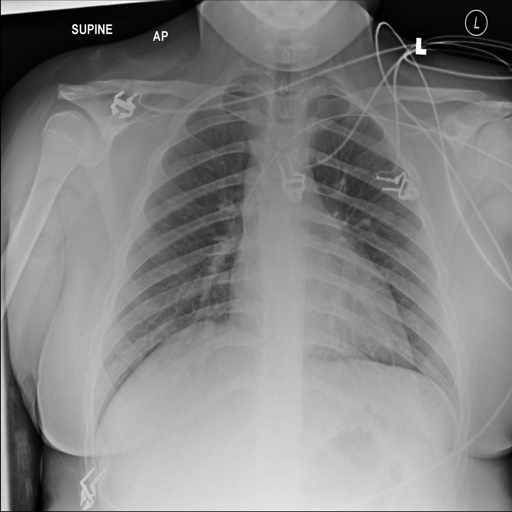

Predicted class: Tuberculosis


In [ ]:
Google_pred('/content/TB_Chest_Radiography_Database/Normal/Normal-1064.png')

# Applying the XAI techniques for the understanding